# Colocalization analysis

(c) Anezka Majkova, January 2024

## Introduction
- code written by Anezka Majkova (version: 7.2.2024), with help from Lukas Schrangl

In this code, we want to calculate the overlay (=colocalization) of two-channel measurement, typically to define a 'dark' fraction of DNA origami platforms - a fraction which carries no fluorophore/protein/etc. 

INPUT: 
- raw data (.SPE files): data of interest & beads data
  - measured simultaneously in two channels (eg. red & green)
  - upload & analyze data for each SLB well separately (you can then make an average over all wells with the same condition)

OUTPUT:
- percentage of overlaid signals in each channel
- representative image of colocalization analysis (raw image + red circles for not colocalized signals + green circles for colocalized signals)


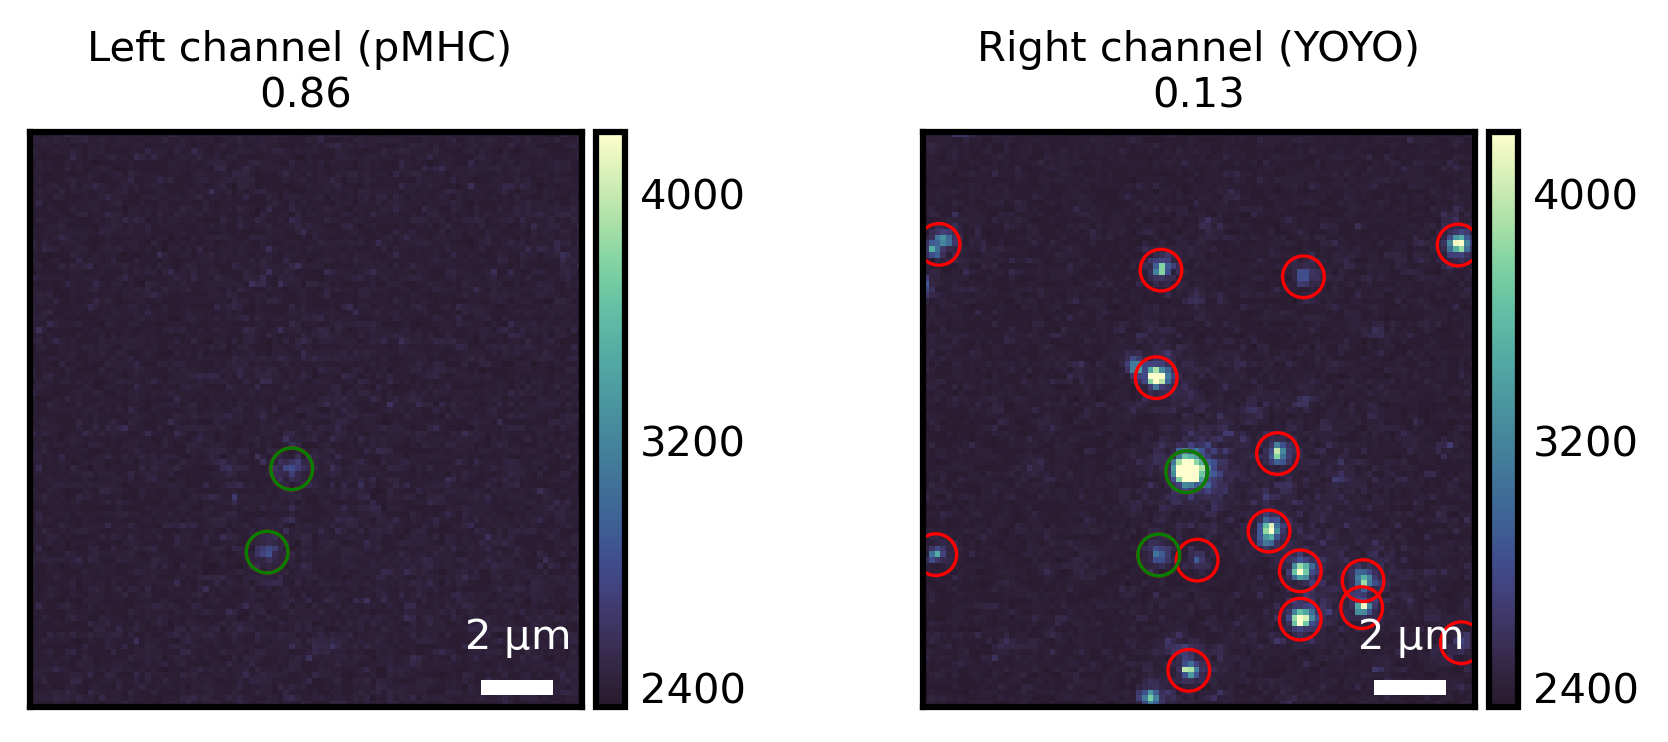


REFERENCE:
- https://schuetzgroup.github.io/sdt-python/motion.html
- https://github.com/schuetzgroup/sdt-python

In [1]:
#required for ChannelSplitter, comment out after 1st widget for STORM data occurs
#%matplotlib widget
%matplotlib inline

#%matplotlib
from pathlib import Path

import matplotlib.pyplot as plt
#plt.ioff()

import numpy as np

import ipywidgets
from sdt import io, loc, motion, multicolor, nbui, brightness, roi
import trackpy
trackpy.quiet()
import traitlets

import pims
#for progressbar
from tqdm.notebook import tqdm, trange


import subprocess
import sys

import pandas as pd
import matplotlib.image as mpimg

import seaborn as sns
import seaborn_image as isns

In [69]:
#data path
data_dir = r"/Users/Schorschi/Desktop/Masterarbeit/LAB-Data/Georg/20250725_tcellactivation_/mSA"
beads_dir = r'/Users/Schorschi/Desktop/Masterarbeit/LAB-Data/Georg/20250724_beads'


bead_filename= ['20250724_beads_001']

#upload the data images, as a list
data_filename=['20250725_msa']

In [70]:
#upload the beads images, as a list, put an asterisk (*) to distinguish between different data files
bead_files = sorted(Path(beads_dir).glob(bead_filename[0]+'*.SPE'))

#upload the data images, as a list
data_files = sorted(Path(data_dir).glob(data_filename[0]+'*.SPE'))

In [71]:
#length of your uploaded data
print(len(data_files),len(bead_files))

32 1


## Chosing a roi 
- assign left and right channels
  - cut your .SPE files (beads & data)
  - save as .tif image
- find the vector (beads) and choose the roi (data) in image-j

### 1. define a vector

In [72]:
#find a vector (distance and slope) for 2-channel ROI alignment
#open the bead file in the image-j

#position of one bead in left channel, coordinates from image-j
left=[124,100]

#position of the corresponding bead in right channel, coordinates from image-j
right=[355,101]

vector=[left[0]-right[0],left[1]-right[1]]


In [73]:
vector

[-231, -1]

### 2. choose a roi

In [74]:
#choose roi in the image-j (size at least (100,100)), left channel
#data files

#coordinates of top left corner of the chosen roi
top_left=[30,30]

#coordinates of bottom right corner of the chosen roi
bottom_right=[150,150]

#create roi based on image-j coordinates
left_roi = roi.ROI((top_left[0], top_left[1]), (bottom_right[0], bottom_right[1]))
right_roi = roi.ROI((top_left[0]-vector[0], top_left[1]-vector[1]), (bottom_right[0]-vector[0],bottom_right[1]-vector[1]))

print('left roi:',left_roi)
print('right roi:',right_roi)

left roi: ROI(top_left=(30, 30), bottom_right=(150, 150), size=(120, 120))
right roi: ROI(top_left=(261, 31), bottom_right=(381, 151), size=(120, 120))


### 3. assign left and right channel

In [8]:
#bead sample

#upload all the stacks from the beads data
bead_imgs = [io.ImageSequence(b).open() for b in bead_files]

#assign left and right roi to all stacks
beads_left = [left_roi(i) for i in bead_imgs]
beads_right = [right_roi(j) for j in bead_imgs]

for i in range(0, len(bead_files)):
    io.save_as_tiff(f'{beads_dir}/'+bead_filename[0]+'_left_'+str(i)+'.tiff', beads_left[i])
    io.save_as_tiff(f'{beads_dir}/'+bead_filename[0]+'_right_'+str(i)+'.tiff', beads_right[i])

In [75]:
#data

#upload all the stacks from the sample data
data_imgs = [io.ImageSequence(b).open() for b in data_files]

#assign left and right roi to all stacks
data_left = [left_roi(i) for i in data_imgs]
data_right = [right_roi(i) for i in data_imgs]

for i in range(0, len(data_files)):
    io.save_as_tiff(f'{data_dir}/'+data_filename[0]+'_left_'+str(i)+'.tiff',data_left[i])
    io.save_as_tiff(f'{data_dir}/'+data_filename[0]+'_right_'+str(i)+'.tiff',data_right[i])

## Channels alignment
- use .tiff beads sample (separated into left and right channel)

In [11]:
#localization: localize right and left channel separately 
sys.executable
subprocess.run([sys.executable, "-m", "sdt.gui.locator"])

/opt/anaconda3/envs/sdt-env/lib/python3.10/runpy.py:126: RuntimeWarning: 'sdt.gui.locator' found in sys.modules after import of package 'sdt.gui', but prior to execution of 'sdt.gui.locator'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
/opt/anaconda3/envs/sdt-env/lib/python3.10/runpy.py:126: RuntimeWarning: 'sdt.gui.locator' found in sys.modules after import of package 'sdt.gui', but prior to execution of 'sdt.gui.locator'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
/opt/anaconda3/envs/sdt-env/lib/python3.10/runpy.py:126: RuntimeWarning: 'sdt.gui.locator' found in sys.modules after import of package 'sdt.gui', but prior to execution of 'sdt.gui.locator'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
/opt/anaconda3/envs/sdt-env/lib/python3.10/site-packages/sdt/io/sm.py:439: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  da

CompletedProcess(args=['/opt/anaconda3/envs/sdt-env/bin/python', '-m', 'sdt.gui.locator'], returncode=0)

In [12]:
#read and upload the localization file, left channel
beads_left =sorted(Path(beads_dir).glob(bead_filename[0]+'_left*.h5'))
beads_left_loc = [io.load(f) for f in beads_left]

In [13]:
#read and upload the localization file, right channel
beads_right =sorted(Path(beads_dir).glob(bead_filename[0]+'_right*.h5'))
beads_right_loc = [io.load(f) for f in beads_right]

In [14]:
beads_left_loc[0]

,x,y,signal,bg,mass,size,frame
0,62.495721,37.104403,18078.226710,992.151014,170592.552592,1.225497,0
1,62.755354,64.504185,17845.318908,939.798887,165381.369183,1.214482,0
2,31.115419,65.730956,15831.872482,814.354277,138243.095647,1.178869,0
3,10.463830,78.338747,10963.513320,622.062350,91158.386460,1.150359,0
4,63.133667,37.715243,20875.367138,1200.463560,192576.958479,1.211700,1
...,...,...,...,...,...,...,...
1800,57.442855,100.267996,23479.911773,793.093899,161262.528747,1.045511,497
1801,36.657094,98.475776,20367.108482,755.911958,143510.405714,1.058978,498
1802,58.068149,100.717066,22613.615446,777.420882,158347.768812,1.055677,498
1803,37.286542,99.089811,20366.166601,743.089347,142538.059468,1.055409,499


In [15]:
beads_right_loc[0]

,x,y,signal,bg,mass,size,frame
0,62.393181,37.546123,24586.719021,1028.335269,182222.706550,1.086078,1
1,62.643770,65.337538,37974.551073,1165.417401,286355.534554,1.095510,1
2,30.727309,66.604118,22882.453981,832.458728,163208.364591,1.065442,1
3,9.872555,79.403959,13170.518995,623.735537,87589.048465,1.028806,1
4,63.042037,38.140403,26409.888087,996.368771,191957.527637,1.075547,2
...,...,...,...,...,...,...,...
1761,56.614631,101.056947,19489.984027,698.619963,144058.701602,1.084611,497
1762,35.693117,99.301539,17235.052590,653.064259,126700.021233,1.081663,498
1763,57.264561,101.553216,19410.372695,697.448273,141472.045170,1.077032,498
1764,36.340152,99.896231,16860.717512,639.765142,121654.966895,1.071611,499


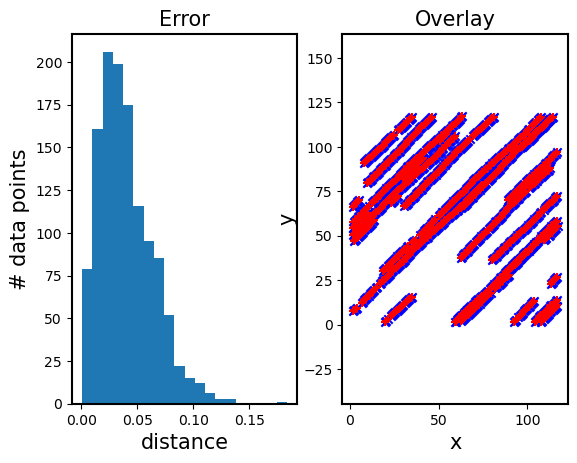

In [16]:
#calculate the transform matrix between right and left channel, by uploading localization data from left and right beads data
reg = multicolor.Registrator(beads_left_loc, beads_right_loc)
reg.determine_parameters()

#plot the error distribution and overlay of the two channels (based on the calculated transform matrix) 
fig, ax = plt.subplots(1, 2)
reg.test(ax=ax)
fig.canvas

## Colocalization 
- use .tiff data sample (separated into left and right channel)
- apply the transform matrix calculated from beads samples to calculate the overlay between data samples 

In [ ]:
#localization: localize right and left channel separately 
sys.executable
subprocess.run([sys.executable, "-m", "sdt.gui.locator"])


/opt/anaconda3/envs/sdt-env/lib/python3.10/runpy.py:126: RuntimeWarning: 'sdt.gui.locator' found in sys.modules after import of package 'sdt.gui', but prior to execution of 'sdt.gui.locator'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
/opt/anaconda3/envs/sdt-env/lib/python3.10/runpy.py:126: RuntimeWarning: 'sdt.gui.locator' found in sys.modules after import of package 'sdt.gui', but prior to execution of 'sdt.gui.locator'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
/opt/anaconda3/envs/sdt-env/lib/python3.10/runpy.py:126: RuntimeWarning: 'sdt.gui.locator' found in sys.modules after import of package 'sdt.gui', but prior to execution of 'sdt.gui.locator'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))


In [50]:
#read and upload the localization file, left channel
data_left =sorted(Path(data_dir).glob(data_filename[0]+'_left*.h5'))
data_left_loc_all = [io.load(f) for f in data_left]

In [51]:
#read and upload the localization file, right channel
data_right =sorted(Path(data_dir).glob(data_filename[0]+'_right*.h5'))
data_right_loc_all = [io.load(f) for f in data_right]


In [52]:
data_left_loc_all[0]

,x,y,signal,bg,mass,size,frame
0,91.975641,8.661630,599.312991,289.184500,5371.545551,1.194353,1
1,61.218230,14.885779,539.916825,285.392132,6233.030717,1.355490,1
2,88.456190,15.841399,680.990959,351.299708,5970.215142,1.181230,1
3,40.729197,17.002226,624.972457,297.128157,7847.232418,1.413637,1
4,67.822318,21.126739,112.442298,262.852045,3432.700420,2.204262,1
...,...,...,...,...,...,...,...
3210,73.377579,17.370539,120.766126,239.009032,1354.031137,1.335832,99
3211,37.466394,37.406965,169.367746,243.319439,1377.457611,1.137716,99
3212,27.846067,92.169605,125.833150,235.216087,1204.149691,1.234107,99
3213,50.282077,102.974102,156.827251,245.980401,2031.817285,1.435958,99


In [53]:
data_right_loc_all[0]

,x,y,signal,bg,mass,size,frame
0,43.565153,35.984200,550.664257,273.541908,3441.185134,0.997288,1
1,70.078238,22.093442,278.714256,283.154219,2279.737398,1.140966,1
2,93.588526,31.568434,335.892851,274.182794,2458.615173,1.079332,1
3,22.585249,58.314069,365.912246,280.988186,2830.486243,1.109563,1
4,90.158737,63.197230,329.080059,286.546448,3330.970299,1.269243,1
...,...,...,...,...,...,...,...
2297,107.917377,37.967522,92.975615,246.546198,717.070110,1.107915,99
2298,27.266486,52.425904,94.178325,242.725871,1106.019107,1.367149,99
2299,39.792211,58.204707,165.680409,246.605077,883.345357,0.921170,99
2300,8.907176,62.257195,86.806108,233.579889,1662.586491,1.745931,99


In [54]:
#work only with the data from the correct frame (to avoid effect of bleaching)
data_right_loc=[]
data_left_loc=[]

for i in range(0, len(data_right_loc_all)):
    data_right_loc.append(data_right_loc_all[i][data_right_loc_all[i]['frame']==1]) #same frame number
    data_left_loc.append(data_left_loc_all[i][data_left_loc_all[i]['frame']==1])

In [55]:
print(len(data_right_loc),len(data_left_loc))

10 10


In [56]:
#transformation of the localizations from right channel to be overlaid with left channel 
#based on the calculation with beads_data

data_right_loc_tr = [reg(d, channel=2) for d in data_right_loc]

In [57]:
#table of all localizations localized in right and left channel
coloc = [multicolor.find_colocalizations(lf, ri, max_dist=2, keep_unmatched=False)
         for lf, ri in zip(data_left_loc, data_right_loc_tr)]


In [58]:
#percentage of colocalized signal in the left and right channel
pcoloc_left = np.around((sum(len(c) for c in coloc) / sum(len(d) for d in data_left_loc)), decimals=2)
pcoloc_right = np.around((sum(len(c) for c in coloc) / sum(len(d) for d in data_right_loc)), decimals=2)

pcoloc_left, pcoloc_right
#type(coloc_right)

(0.28, 0.69)

# plot colocalization

- representative image of colocalization analysis (raw image + red circles for not colocalized signals + green circles for colocalized signals)
- raw image taken from one chosen position, the percenatge included is the mean per analysed well (eg. 10 different positions)

In [59]:
%matplotlib inline
#plt.ioff()

In [60]:
#list of data (bad ordering, check the order to be able to assign data to an image)
data_right

[PosixPath('/Users/Schorschi/Desktop/Masterarbeit/LAB-Data/Georg/20250725_tcellactivation_/L2/10ng/20250725_L2_10ng_slb1_right_0.h5'),
 PosixPath('/Users/Schorschi/Desktop/Masterarbeit/LAB-Data/Georg/20250725_tcellactivation_/L2/10ng/20250725_L2_10ng_slb1_right_1.h5'),
 PosixPath('/Users/Schorschi/Desktop/Masterarbeit/LAB-Data/Georg/20250725_tcellactivation_/L2/10ng/20250725_L2_10ng_slb1_right_2.h5'),
 PosixPath('/Users/Schorschi/Desktop/Masterarbeit/LAB-Data/Georg/20250725_tcellactivation_/L2/10ng/20250725_L2_10ng_slb1_right_3.h5'),
 PosixPath('/Users/Schorschi/Desktop/Masterarbeit/LAB-Data/Georg/20250725_tcellactivation_/L2/10ng/20250725_L2_10ng_slb1_right_4.h5'),
 PosixPath('/Users/Schorschi/Desktop/Masterarbeit/LAB-Data/Georg/20250725_tcellactivation_/L2/10ng/20250725_L2_10ng_slb1_right_5.h5'),
 PosixPath('/Users/Schorschi/Desktop/Masterarbeit/LAB-Data/Georg/20250725_tcellactivation_/L2/10ng/20250725_L2_10ng_slb1_right_6.h5'),
 PosixPath('/Users/Schorschi/Desktop/Masterarbeit/LAB-D

In [61]:
data_files

[PosixPath('/Users/Schorschi/Desktop/Masterarbeit/LAB-Data/Georg/20250725_tcellactivation_/L2/10ng/20250725_L2_10ng_slb1__000_.SPE'),
 PosixPath('/Users/Schorschi/Desktop/Masterarbeit/LAB-Data/Georg/20250725_tcellactivation_/L2/10ng/20250725_L2_10ng_slb1__001_.SPE'),
 PosixPath('/Users/Schorschi/Desktop/Masterarbeit/LAB-Data/Georg/20250725_tcellactivation_/L2/10ng/20250725_L2_10ng_slb1__002_.SPE'),
 PosixPath('/Users/Schorschi/Desktop/Masterarbeit/LAB-Data/Georg/20250725_tcellactivation_/L2/10ng/20250725_L2_10ng_slb1__003_.SPE'),
 PosixPath('/Users/Schorschi/Desktop/Masterarbeit/LAB-Data/Georg/20250725_tcellactivation_/L2/10ng/20250725_L2_10ng_slb1__004_.SPE'),
 PosixPath('/Users/Schorschi/Desktop/Masterarbeit/LAB-Data/Georg/20250725_tcellactivation_/L2/10ng/20250725_L2_10ng_slb1__005_.SPE'),
 PosixPath('/Users/Schorschi/Desktop/Masterarbeit/LAB-Data/Georg/20250725_tcellactivation_/L2/10ng/20250725_L2_10ng_slb1__006_.SPE'),
 PosixPath('/Users/Schorschi/Desktop/Masterarbeit/LAB-Data/Geo

In [62]:
#upload an image of chosen dataset and frame
with io.ImageSequence(data_files[0]) as ims:
    img = ims[1]

In [63]:
img

Image([[287, 258, 251, ..., 238, 223, 258],
       [226, 229, 230, ..., 234, 236, 221],
       [230, 239, 240, ..., 233, 288, 238],
       ...,
       [239, 209, 232, ..., 221, 205, 216],
       [207, 220, 251, ..., 208, 234, 236],
       [206, 224, 240, ..., 228, 213, 215]], dtype=uint16)

In [64]:
#transformation of the localizations from right channel to be overlaid with left channel
#based on the calculation with beads_data
#transformation needs to be calculated in order to overlaid image with localization data
data_left_loc_tr = [reg(d, channel=1) for d in data_left_loc]

coloc_left = [multicolor.find_colocalizations(lf, ri, max_dist=2, keep_unmatched=False)
         for lf, ri in zip(data_left_loc_tr, data_right_loc)]

print(len(coloc), len(coloc_left))

10 10


In [65]:
#uplod localized data from right channel, choose one dataset (eg. first one)
data_right_plot=pd.DataFrame(data_right_loc[0])

#choose only one frame from chosen dataset (eg. first one)
frame_right=data_right_plot['frame']==1

#x,y coordinates of localization from the chosen frame and dataset
xright_frame=data_right_plot['x'][frame_right]
yright_frame=data_right_plot['y'][frame_right]

print(len(xright_frame), len(yright_frame))
#print(data_right_loc)

38 38


In [66]:
#uplod localized data from left channel, choose dataset same as for the right channel
data_left_plot=pd.DataFrame(data_left_loc[0])

#choose only one frame from chosen dataset (eg. first one)
frame_left=data_left_plot['frame']==1

#x,y coordinates of localization from the chosen frame and dataset
xleft_frame=data_left_plot['x'][frame_left]
yleft_frame=data_left_plot['y'][frame_left]

print(len(xleft_frame), len(yleft_frame))

83 83


In [67]:
#uplod localized data from coloc list, choose same dataset as for right channel
coloc_plot=pd.DataFrame(coloc_left[0])
coloc_plot_left=pd.DataFrame(coloc[0])

#choose only one frame from chosen dataset (eg. first one)
frame_coloc=coloc_plot['channel2']['frame']==1

#x,y coordinates of localization from the chosen frame and dataset, right channel
xcoloc_frame_right=coloc_plot['channel2']['x'][frame_coloc]
ycoloc_frame_right=coloc_plot['channel2']['y'][frame_coloc]

#x,y coordinates of localization from the chosen frame and dataset, left channel
xcoloc_frame_left=coloc_plot_left['channel1']['x'][frame_coloc]
ycoloc_frame_left=coloc_plot_left['channel1']['y'][frame_coloc]

print('right channel:', len(xcoloc_frame_right), len(ycoloc_frame_right), '; left channel:',len(xcoloc_frame_left), len(ycoloc_frame_left))

right channel: 28 28 ; left channel: 28 28


## plot the final colocalization image

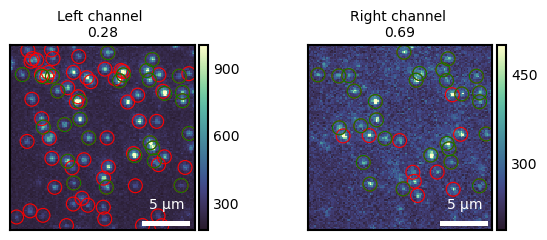

In [68]:
fig, ax = plt.subplots(1, 2)
plt.subplots_adjust(wspace=0.5)


sns.scatterplot(x=xright_frame, y=yright_frame, marker="o", s=100, facecolors='none', edgecolors='r', ax=ax[1])
sns.scatterplot(x=xcoloc_frame_right, y=ycoloc_frame_right, marker="o", s=100, facecolors='none', edgecolors='g', ax=ax[1])
sns.scatterplot(x=xleft_frame, y=yleft_frame, marker="o", s=100, facecolors='none', edgecolors='r',  ax=ax[0])
sns.scatterplot(x=xcoloc_frame_left, y=ycoloc_frame_left, marker="o", s=100, facecolors='none', edgecolors='g', ax=ax[0])

#if gray=True, the image in gray, otherwise RGB image
#default color bar setting: vmin=None, vmax=None; meaning color bar is set automatically but can be adjusted to more reasonable values, eg. vmax=4200 
isns.imgplot(right_roi(img), gray=False, vmin=None, vmax= 500, dx=0.160, units='um', ax=ax[1])
isns.imgplot(left_roi(img), gray=False, vmin=None, vmax= 1000,dx=0.160, units='um', ax=ax[0])

#caption (change to what applies for your sample)

ax[0].set_title('Left channel \n'+str(pcoloc_left), size=10)
ax[1].set_title("Right channel \n"+str(pcoloc_right), size=10)

#save the plot
fig.savefig(f'{data_dir}/'+data_filename[0]+'_coloc.png')